# Players Exploration
This notebook analyzes merged player data: distributions, correlations, and country-level market values.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [2]:
# Load merged cleaned dataset
df = pd.read_csv("../Data/Merged/merged_players_clean.csv", encoding="utf-8-sig")
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
df["log_value"] = np.log1p(df["market_value_eur"]) #clear the skewed data and log them to increase the visibility

## Correlations with Market Value

In [3]:

cols = [
    "market_value_eur",
    "overall_rating", "potential",
    "age", "height_cm", "weight_kg",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "power_stamina"
]
df_corr = df[cols].corr()
df_corr["market_value_eur"].sort_values(ascending=False)

market_value_eur             1.000000
overall_rating               0.665794
potential                    0.612018
skill_dribbling              0.240746
attacking_finishing          0.192218
power_stamina                0.130196
defending_standing_tackle    0.095994
height_cm                    0.026637
weight_kg                    0.009467
age                         -0.055058
Name: market_value_eur, dtype: float64

In [4]:
num_cols = [
    "market_value_eur",
    "overall_rating", "potential",
    "age",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "power_stamina"
]

corr = df[num_cols].corr()
corr

,market_value_eur,overall_rating,potential,age,attacking_finishing,skill_dribbling,defending_standing_tackle,power_stamina
market_value_eur,1.000000,0.665794,0.612018,-0.055058,0.192218,0.240746,0.095994,0.130196
overall_rating,0.665794,1.000000,0.691969,0.029395,0.173284,0.219789,0.133738,0.114418
potential,0.612018,0.691969,1.000000,-0.134808,0.119359,0.218176,0.082256,0.064368
age,-0.055058,0.029395,-0.134808,1.000000,-0.113663,-0.136002,-0.030464,-0.106742
attacking_finishing,0.192218,0.173284,0.119359,-0.113663,1.000000,0.840542,0.056918,0.586823
skill_dribbling,0.240746,0.219789,0.218176,-0.136002,0.840542,1.000000,0.402108,0.734382
defending_standing_tackle,0.095994,0.133738,0.082256,-0.030464,0.056918,0.402108,1.000000,0.576279
power_stamina,0.130196,0.114418,0.064368,-0.106742,0.586823,0.734382,0.576279,1.000000


## Distributions

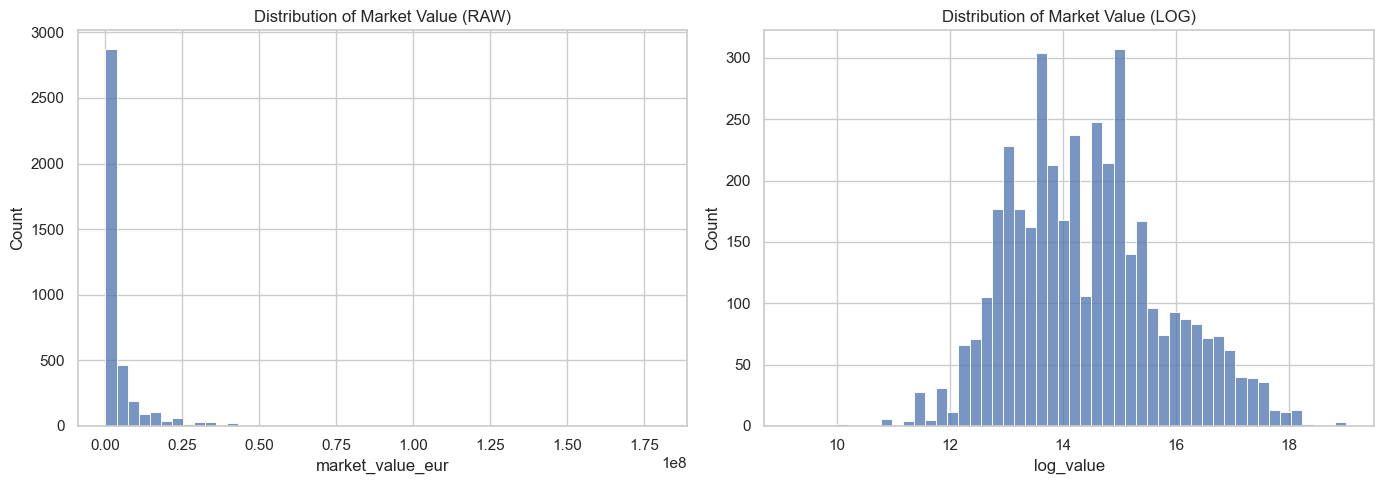

In [5]:

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df["market_value_eur"], bins=50, ax=axes[0])
axes[0].set_title("Distribution of Market Value (RAW)")

sns.histplot(df["log_value"], bins=50, ax=axes[1])
axes[1].set_title("Distribution of Market Value (LOG)")

plt.tight_layout()
plt.show()

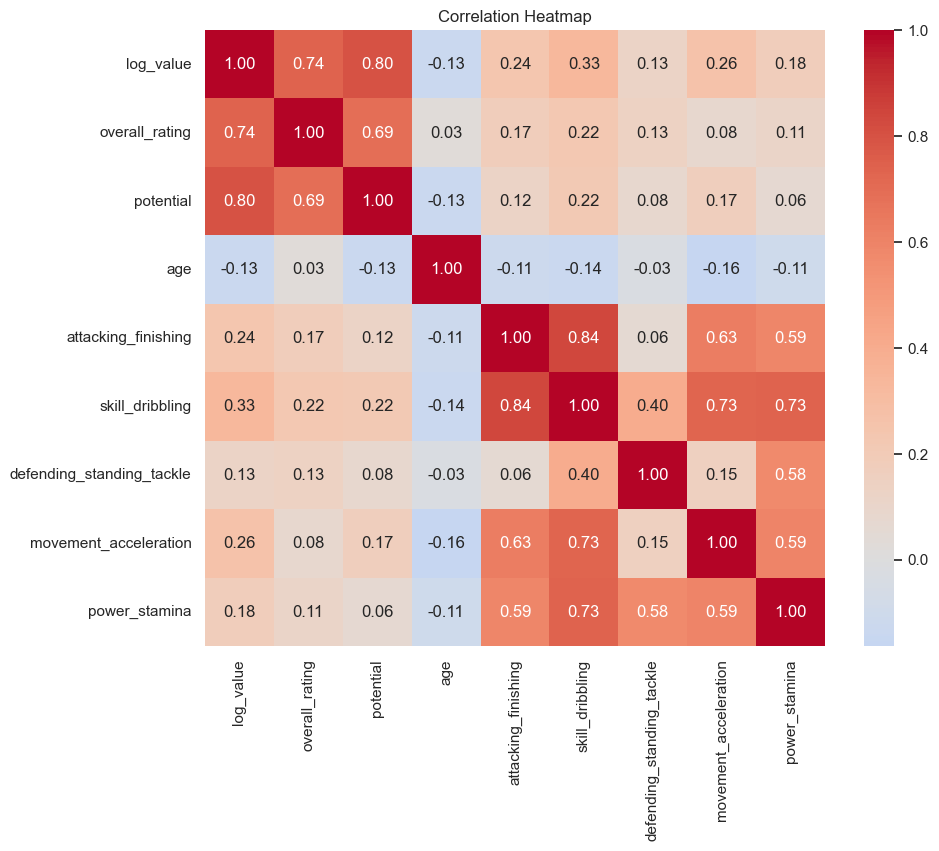

In [6]:
# Correlations (Heatmap)
cols = [
    "log_value",
    "overall_rating", "potential", "age",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "movement_acceleration",
    "power_stamina"
]

corr = df[cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap")
plt.show()

## Country-Level View

In [7]:

country_avg = (
    df.groupby("country_name")["market_value_eur"]
    .mean()
    .reset_index()
)

fig = px.choropleth(
    country_avg,
    locations="country_name",
    locationmode="country names",
    color="market_value_eur",
    hover_name="country_name",
    color_continuous_scale="Viridis",
    title="Average Market Value by Country",
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Avg Market Value (€)")
)

fig.show()

## Top Players per Country (Hover)

In [8]:
# Build a "top players" hover text

def top_players(country, n=3):
    players = (
        df[df["country_name"] == country]
        .sort_values("market_value_eur", ascending=False)
        .head(n)
    )
    return "<br>".join(
        f"{row['full_name']} — €{int(row['market_value_eur']):,}"
        for _, row in players.iterrows()
    )

country_avg["top_players"] = country_avg["country_name"].apply(top_players)

In [9]:
fig = px.choropleth(
    country_avg,
    locations="country_name",
    locationmode="country names",
    color="market_value_eur",
    hover_name="country_name",
    hover_data={"top_players": True, "market_value_eur": False},
    color_continuous_scale="Plasma",
    title="Average Market Value + Top Players by Country",
)

fig.show()

## features reduction suggestions 

since there are a lot of features (190+) this is a concise feature reduction recommendation to readuce the features up to 62 important features

In [10]:
# Convert dob -> age/year_of_birth if not already done
current_year = pd.Timestamp.today().year

if "dob" in df.columns:
    df["dob"] = pd.to_datetime(df["dob"], errors="coerce", dayfirst=True)
    if "age" not in df.columns:
        df["age"] = current_year - df["dob"].dt.year
    if "year_of_birth" not in df.columns:
        df["year_of_birth"] = df["dob"].dt.year
else:
    # Keep the pipeline robust if dob is absent
    if "year_of_birth" not in df.columns:
        df["year_of_birth"] = np.nan

# Final feature list
features = [
    # Core bio
    "height_cm", "weight_kg", "age", "year_of_birth",
    "preferred_foot", "weak_foot", "skill_moves",
    "international_reputation",

    # Overall + potential
    "overall_rating", "potential",

    # Attacking
    "attacking_crossing", "attacking_finishing",
    "attacking_heading_accuracy", "attacking_short_passing",
    "attacking_volleys",

    # Skill
    "skill_dribbling", "skill_curve", "skill_fk_accuracy",
    "skill_long_passing", "skill_ball_control",

    # Movement
    "movement_acceleration", "movement_sprint_speed",
    "movement_agility", "movement_reactions",
    "movement_balance",

    # Power
    "power_shot_power", "power_jumping", "power_stamina",
    "power_strength", "power_long_shots",

    # Mentality
    "mentality_aggression", "mentality_interceptions",
    "mentality_vision", "mentality_penalties",
    "mentality_composure", "mentality_attack_position",

    # Defending
    "defending_defensive_awareness", "defending_standing_tackle",
    "defending_sliding_tackle",

    # Positional ratings
    "CAM", "CB", "CDM", "CM", "LB", "LM", "LW", "RB", "RM", "RW", "ST",
    "CAM.1", "CB.1", "CDM.1", "CM.1", "LB.1", "LM.1", "LW.1",
    "RB.1", "RM.1", "RW.1", "ST.1",

    # Contextual
    "country_name",

    # Target
    "market_value_eur",
]

# Create the final filtered DataFrame (robust to missing columns)
missing_features = [c for c in features if c not in df.columns]
if missing_features:
    print("Missing columns (skipped):", missing_features)

df_final = df[[c for c in features if c in df.columns]].copy()

df_final.head()

C:\Users\job\AppData\Local\Temp\ipykernel_6168\2580356483.py:5: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



,height_cm,weight_kg,age,year_of_birth,preferred_foot,weak_foot,skill_moves,international_reputation,overall_rating,potential,...,CM.1,LB.1,LM.1,LW.1,RB.1,RM.1,RW.1,ST.1,country_name,market_value_eur
0,182.0,81.0,26.0,1998,Right,4,5,5,91,94,...,0,0,0,0,0,0,0,1,France,180000000.0
1,186.0,75.0,22.0,2003,Right,4,4,5,90,94,...,0,0,0,0,0,0,0,0,England,180000000.0
2,195.0,94.0,25.0,2000,Left,3,3,5,90,92,...,0,0,0,0,0,0,0,1,Norway,180000000.0
3,178.0,67.0,28.0,1997,Left,5,5,5,90,90,...,0,0,0,0,0,0,0,1,France,100000000.0
4,182.0,78.0,27.0,1998,Right,4,3,4,89,90,...,1,0,0,0,0,0,0,0,Uruguay,130000000.0


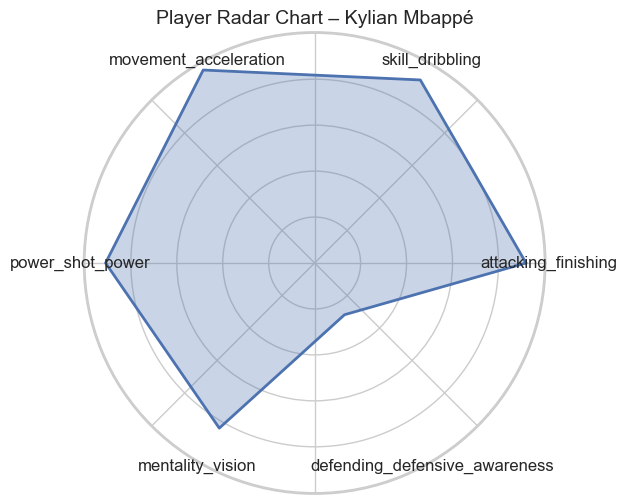

In [11]:
from math import pi
import matplotlib.pyplot as plt

# stats to compare
stats = ["attacking_finishing", "skill_dribbling", "movement_acceleration",
         "power_shot_power", "mentality_vision", "defending_defensive_awareness"]

player = df[df["full_name"] == "Kylian Mbappé"].iloc[0]

# Extract values
values = [player[s] for s in stats]
values += values[:1]  # close the loop

# Compute angles
angles = [n / float(len(stats)) * 2 * pi for n in range(len(stats))]
angles += angles[:1]

# Plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Remove angle labels (degrees)
ax.set_xticklabels([])

# Optional: remove radial labels too
ax.set_yticklabels([])

# Draw the polygon
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.3)

# Add stat labels manually around the circle
for angle, label in zip(angles[:-1], stats):
    ax.text(angle, max(values) + 5, label, ha='center', va='center')

plt.title("Player Radar Chart – Kylian Mbappé", fontsize=14)
plt.show()


## Advanced Visualizations (t-SNE, PCA, Correlations)
These cells add richer global views: feature-feature correlations, feature-target correlations, PCA projections, and t-SNE embeddings.

In [12]:
# Setup: reduced feature set + sensible cleaning for correlation/PCA/t-SNE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set_theme(style="whitegrid")

# Ensure year_of_birth exists if dob is present (important feature)
if "year_of_birth" not in df.columns and "dob" in df.columns:
    df["dob"] = pd.to_datetime(df["dob"], errors="coerce", dayfirst=True)
    df["year_of_birth"] = df["dob"].dt.year

# Choose target (prefer log_value if available)
if "log_value" in df.columns:
    target_col = "log_value"
elif "market_value_eur" in df.columns:
    df["market_value_eur"] = pd.to_numeric(df["market_value_eur"], errors="coerce")
    df["log_value"] = np.log1p(df["market_value_eur"])
    target_col = "log_value"
else:
    raise ValueError("Expected 'log_value' or 'market_value_eur' in df.")

# Use your curated feature list if it exists (from the earlier 'features reduction' cell).
# Otherwise, fall back to all columns.
base_features = list(features) if "features" in globals() else df.columns.tolist()

# Remove target leakage only
leakage_cols = {"market_value_eur", "log_value", target_col}
base_features = [c for c in base_features if c not in leakage_cols]

# Drop ID-like / index-like columns that don't represent player skill
explicit_drop = {
    "player_id", "player_id_tm", "player_id_sofifa",
    "sofifa_id", "club_id_tm", "club_kit_number",
    "club_league_id", "club_id", "id",
}
base_features = [c for c in base_features if c not in explicit_drop]

# Optional: remove duplicated positional columns ('.1') to avoid double-counting
base_features = [c for c in base_features if not str(c).endswith(".1")]

# Keep only features present in df
base_features = [c for c in base_features if c in df.columns]

# Build raw feature frame
X_raw = df[base_features].copy()

# Numeric-only for correlations
X_num = X_raw.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# For PCA/t-SNE: numeric + small, meaningful categorical encoding
cat_embed = [c for c in ["preferred_foot"] if c in X_raw.columns]
num_embed = [c for c in X_raw.columns if c in X_num.columns and c != target_col]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_embed),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_embed),
    ],
    remainder="drop",
)

X_scaled = preprocess.fit_transform(X_raw)
y = df[target_col].to_numpy()

print(
    f"Rows: {len(df)}, selected features: {len(base_features)} | "
    f"numeric corr features: {X_num.shape[1]} | "
    f"embed dims: {X_scaled.shape[1]} | target: {target_col}"
)

Rows: 3977, selected features: 51 | numeric corr features: 49 | embed dims: 51 | target: log_value


### PCA-based feature selection report (for the correlation heatmap)
This section selects a readable subset of numeric attributes using PCA (keep PCs until a variance threshold, then rank original features by weighted PCA loadings). It then prints the selected attributes and a normalized contribution percentage for transparency.

PCA variance reached with 19 PCs: 90.29% (threshold=90%)
Selected features for correlation heatmap: 30


,feature,pca_score,pct_of_selected_total,must_include
0,height_cm,0.113802,3.737695,True
1,weight_kg,0.106005,3.481604,True
2,overall_rating,0.094219,3.094509,True
3,skill_moves,0.093566,3.073073,True
4,potential,0.090944,2.986962,True
5,weak_foot,0.089527,2.940418,True
6,international_reputation,0.080487,2.643505,True
7,year_of_birth,0.075889,2.492481,True
8,age,0.072440,2.379209,True
9,movement_acceleration,0.117793,3.868767,False


Selected features (in heatmap order = must-include first, then PCA-ranked):
['overall_rating', 'potential', 'age', 'year_of_birth', 'height_cm', 'weight_kg', 'international_reputation', 'weak_foot', 'skill_moves', 'movement_acceleration', 'movement_agility', 'movement_balance', 'attacking_finishing', 'attacking_volleys', 'movement_sprint_speed', 'power_long_shots', 'mentality_penalties', 'skill_long_passing', 'mentality_vision', 'power_shot_power', 'attacking_heading_accuracy', 'mentality_attack_position', 'power_stamina', 'defending_standing_tackle', 'power_jumping', 'mentality_interceptions', 'attacking_short_passing', 'mentality_composure', 'defending_defensive_awareness', 'defending_sliding_tackle']


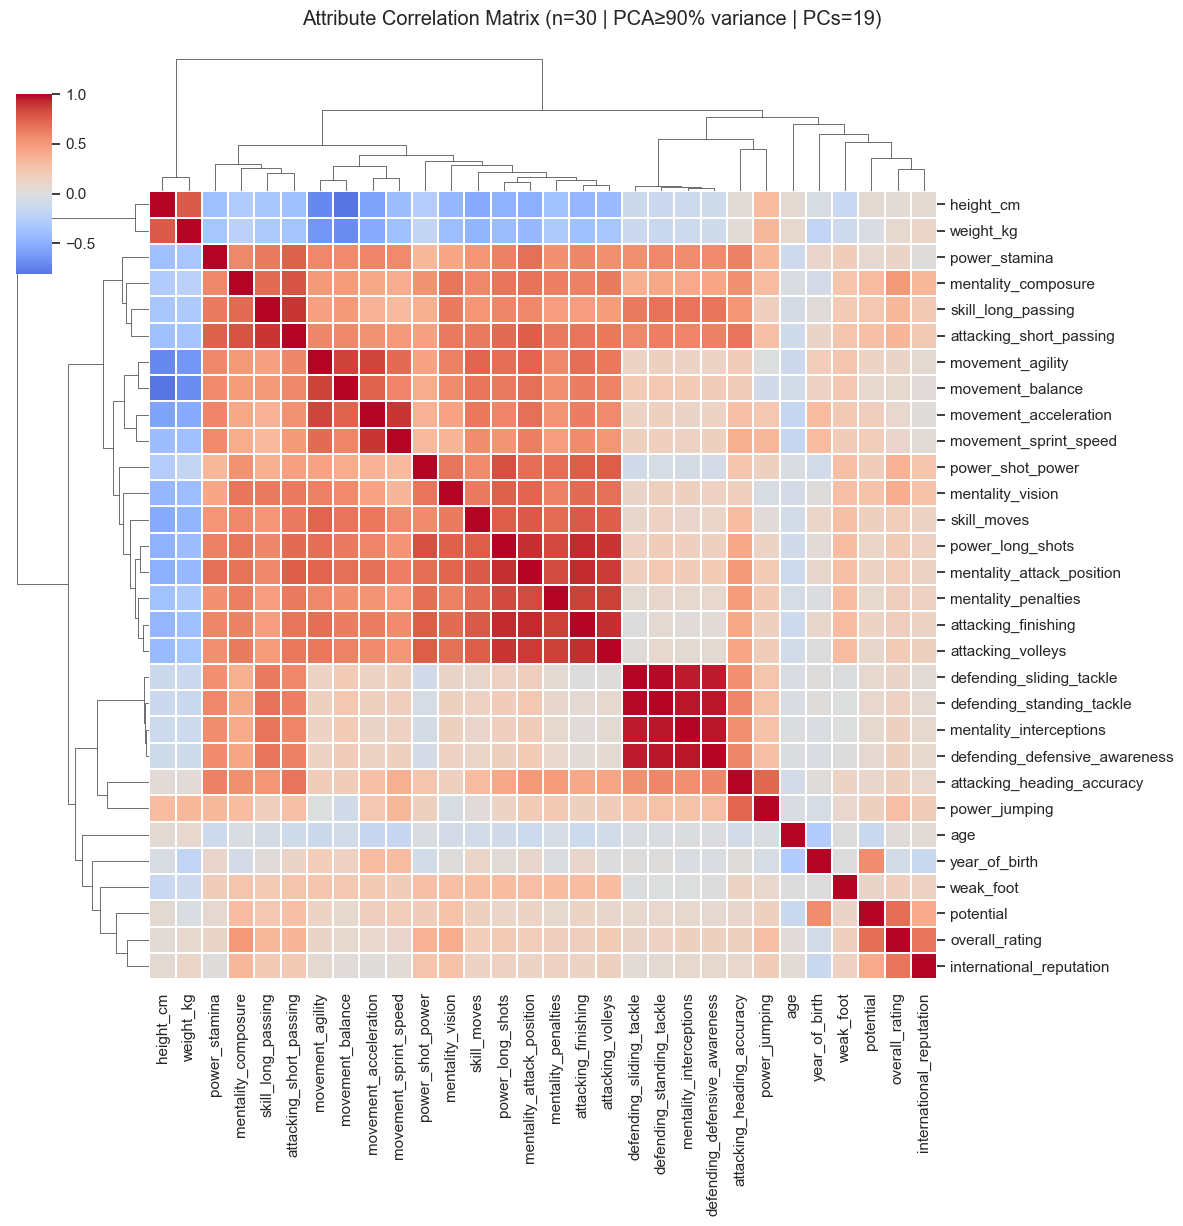

In [19]:
# Correlation matrix BETWEEN attributes (clustered heatmap)

# Better feature selection idea:
# - Run PCA on standardized numeric features
# - Keep enough PCs to reach a chosen explained-variance threshold
# - Score original features by their weighted PCA loadings
# - Plot a readable clustermap for the top-K scored features (plus must-include)

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1) Must-include features (domain important)
must_include = [
    "overall_rating",
    "potential",
    "age",
    "year_of_birth",
    "height_cm",
    "weight_kg",
    "international_reputation",
    "weak_foot",
    "skill_moves",
]

# Only keep must-include columns that actually exist in the numeric frame
must_include_present = [c for c in must_include if c in X_num.columns]

# 2) PCA-based scoring over numeric features
variance_threshold = 0.90  # choose 0.85/0.90/0.95
top_k = 30  # total features shown in the heatmap

num_cols_all = X_num.columns.tolist()
X_num_clean = X_num[num_cols_all].copy()

# Impute + scale for PCA (PCA expects no NaNs and benefits from scaling)
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
X_imp = imputer.fit_transform(X_num_clean)
X_std = scaler.fit_transform(X_imp)

# Fit PCA with all components, then find how many are needed for the threshold
pca_full = PCA(n_components=min(X_std.shape[0], X_std.shape[1]), random_state=42)
pca_full.fit(X_std)

cum = np.cumsum(pca_full.explained_variance_ratio_)
n_components = int(np.searchsorted(cum, variance_threshold) + 1)
n_components = max(2, min(n_components, pca_full.components_.shape[0]))

# Components matrix shape: (n_components_total, n_features)
components = pca_full.components_[:n_components, :]
weights = pca_full.explained_variance_ratio_[:n_components]

# Feature score: sum over retained PCs of |loading| * explained_variance_ratio
scores = (np.abs(components).T @ weights)
score_s = pd.Series(scores, index=num_cols_all).sort_values(ascending=False)

# 3) Choose remaining features by PCA score, excluding must-include already present
remaining_slots = max(0, top_k - len(must_include_present))
pca_ranked = [c for c in score_s.index if c not in must_include_present]
selected_by_pca = pca_ranked[:remaining_slots]

selected_features = must_include_present + selected_by_pca

# --- Reporting: selected attributes + PCA-based contribution proxy ---
var_reached = float(cum[n_components - 1]) * 100
print(f"PCA variance reached with {n_components} PCs: {var_reached:.2f}% (threshold={variance_threshold*100:.0f}%)")
print(f"Selected features for correlation heatmap: {len(selected_features)}")

selected_scores = score_s.loc[selected_features].sort_values(ascending=False)
report = pd.DataFrame({
    "feature": selected_scores.index,
    "pca_score": selected_scores.values,
    "pct_of_selected_total": (selected_scores / selected_scores.sum() * 100).values,
    "must_include": [f in set(must_include_present) for f in selected_scores.index],
})
report = report.sort_values(["must_include", "pct_of_selected_total"], ascending=[False, False]).reset_index(drop=True)

display(report)

print("Selected features (in heatmap order = must-include first, then PCA-ranked):")
print(selected_features)

corr_attr = X_num[selected_features].corr(numeric_only=True)

g = sns.clustermap(
    corr_attr,
    cmap="coolwarm",
    center=0,
    linewidths=0.2,
    figsize=(12, 12),
    dendrogram_ratio=(0.15, 0.15),
    cbar_pos=(0.02, 0.8, 0.03, 0.15),
)
g.figure.suptitle(
    f"Attribute Correlation Matrix (n={len(selected_features)} | PCA≥{int(variance_threshold*100)}% variance | PCs={n_components})",
    y=1.02,
 )
plt.show()

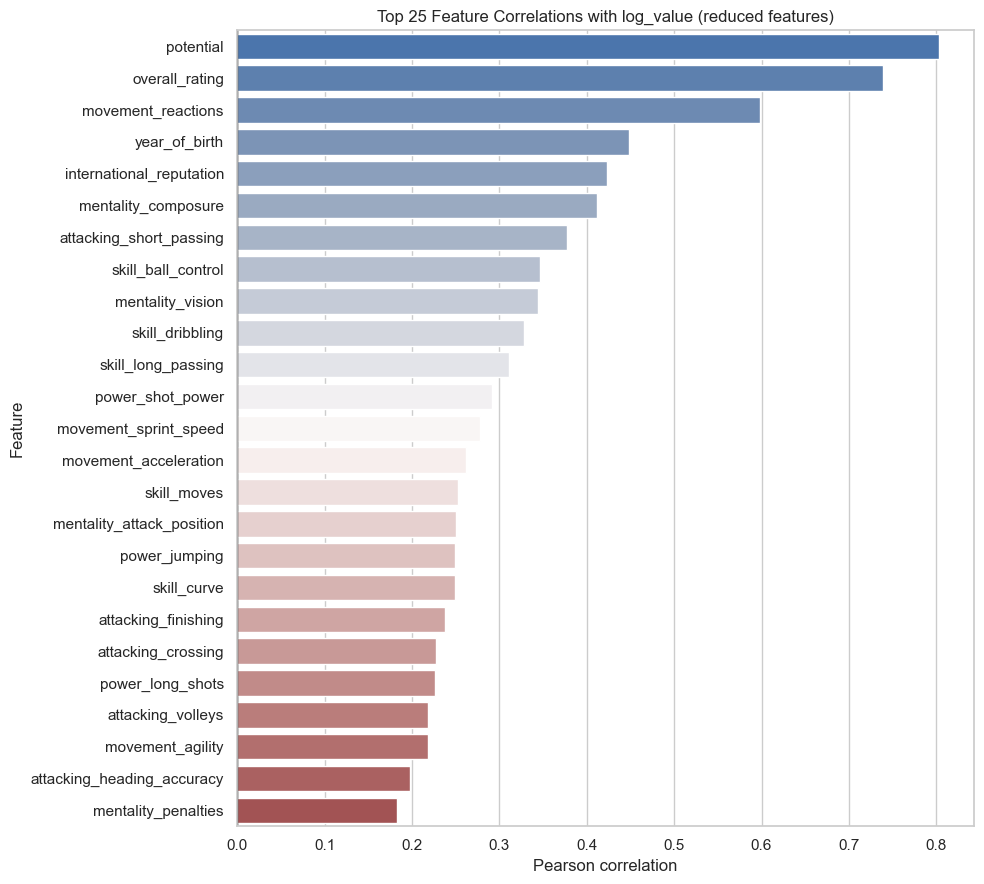

,corr_with_log_value
potential,0.802985
overall_rating,0.739039
movement_reactions,0.598650
year_of_birth,0.448692
international_reputation,0.422823
mentality_composure,0.411497
attacking_short_passing,0.377369
skill_ball_control,0.346464
mentality_vision,0.343809
skill_dribbling,0.328169


In [14]:
# Correlation of numeric attributes with the target (using reduced feature set)

# Compute correlations on reduced numeric feature set only
corr_with_target = (
    pd.concat([X_num, df[[target_col]]], axis=1)
    .corr(numeric_only=True)[target_col]
    .drop(index=target_col)
    .sort_values(key=lambda s: s.abs(), ascending=False)
 )

top_n = 25
top_df = corr_with_target.head(top_n).reset_index()
top_df.columns = ["feature", "corr"]

plt.figure(figsize=(10, 9))
ax = sns.barplot(
    data=top_df,
    x="corr",
    y="feature",
    hue="feature",
    palette="vlag",
    dodge=False,
    legend=False,
 )
ax.axvline(0, color="black", linewidth=1)
plt.title(f"Top {top_n} Feature Correlations with {target_col} (reduced features)")
plt.xlabel("Pearson correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

display(corr_with_target.to_frame(name=f"corr_with_{target_col}").head(50))

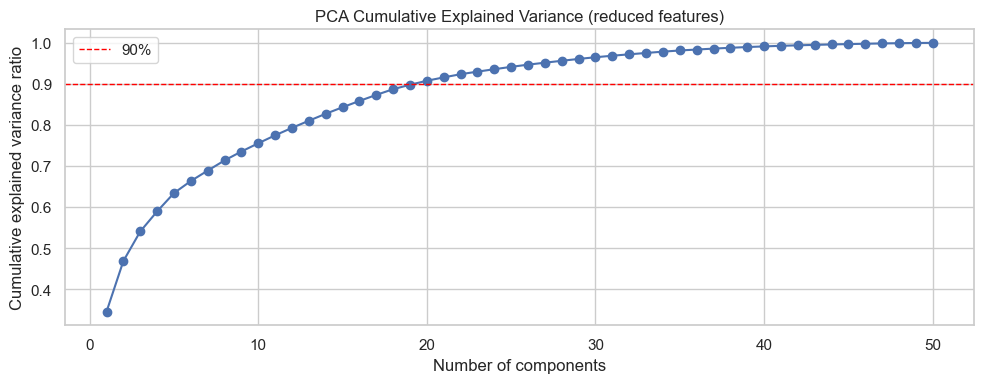

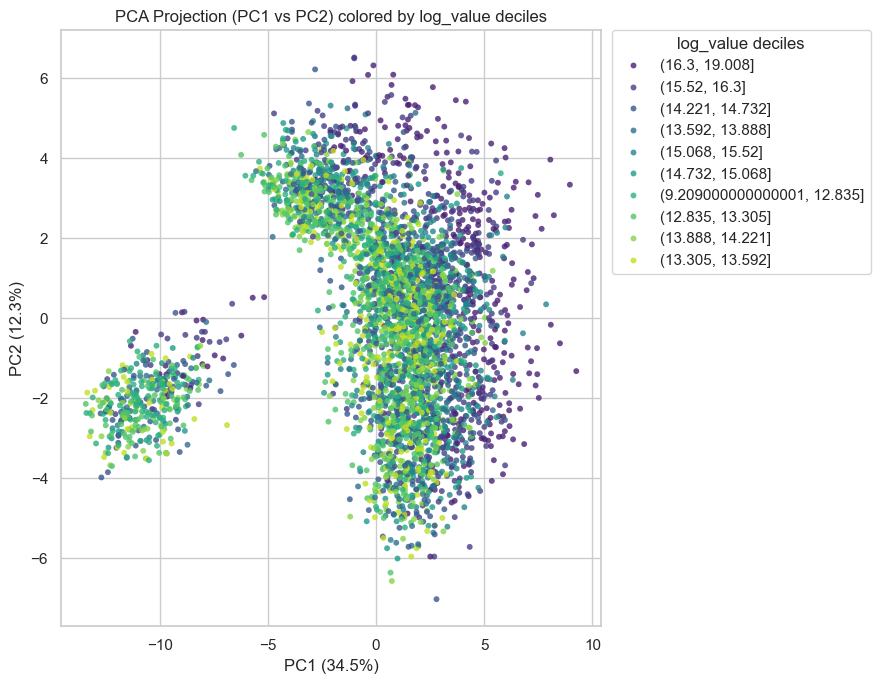

In [15]:
# PCA (explained variance + 2D projection) on reduced/cleaned embedding features

from sklearn.decomposition import PCA

pca = PCA(n_components=min(50, X_scaled.shape[1]), random_state=42)
Z = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(cum_explained) + 1), cum_explained, marker="o")
plt.axhline(0.9, color="red", linestyle="--", linewidth=1, label="90%")
plt.title("PCA Cumulative Explained Variance (reduced features)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.legend()
plt.tight_layout()
plt.show()

# 2D PCA scatter colored by target deciles
q = pd.qcut(df[target_col], q=10, duplicates="drop")
plt.figure(figsize=(9, 7))
sns.scatterplot(
    x=Z[:, 0], y=Z[:, 1],
    hue=q.astype(str),
    palette="viridis",
    s=18, linewidth=0, alpha=0.8,
 )
plt.title(f"PCA Projection (PC1 vs PC2) colored by {target_col} deciles")
plt.xlabel(f"PC1 ({explained[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}%)")
plt.legend(title=f"{target_col} deciles", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

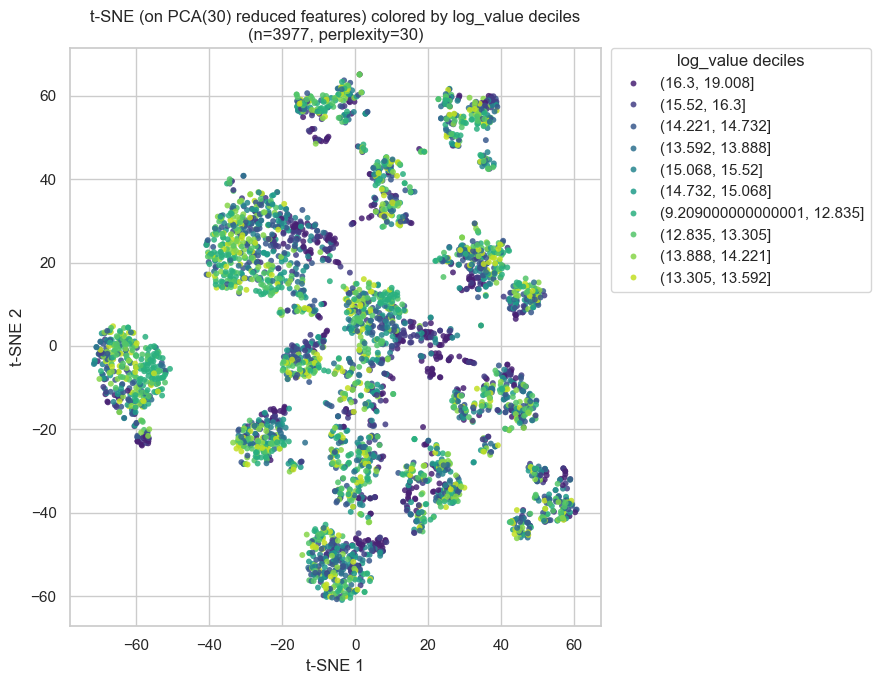

In [16]:
# t-SNE (PCA-precompressed + colored by target) on reduced/cleaned embedding features

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Speed/quality tradeoff: compress before t-SNE
pca_tsne = PCA(n_components=min(30, X_scaled.shape[1]), random_state=42)
X_30 = pca_tsne.fit_transform(X_scaled)

# Optional: subsample for performance on large datasets
n = X_30.shape[0]
max_points = 5000
rng = np.random.default_rng(42)
idx = np.arange(n) if n <= max_points else rng.choice(n, size=max_points, replace=False)

# Keep perplexity valid (must be < n_samples)
perplexity = min(30, max(5, (len(idx) - 1) // 3))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    init="pca",
    random_state=42,
 )
T = tsne.fit_transform(X_30[idx])

q = pd.qcut(df.iloc[idx][target_col], q=10, duplicates="drop")
plt.figure(figsize=(9, 7))
sns.scatterplot(
    x=T[:, 0], y=T[:, 1],
    hue=q.astype(str),
    palette="viridis",
    s=18, linewidth=0, alpha=0.85,
 )
plt.title(
    f"t-SNE (on PCA(30) reduced features) colored by {target_col} deciles\n"
    f"(n={len(idx)}, perplexity={perplexity})"
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title=f"{target_col} deciles", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()